In [237]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geocoder 
import folium
import json
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
import matplotlib.cm as cm
import matplotlib.colors as colors


# Data Gathering

In [79]:
#get html page
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_data=requests.get(url)
#create an object from BeautifulSoup with html data
soup=BeautifulSoup(html_data.content,'html.parser')
# extract table from entire html page
table=soup.find('table',attrs={'class':'wikitable'})
# get table rows
rows=table.find_all('tr')

In [80]:
# extract text from table cells as columns(header , th) and data (td)
columns=[]
data=[]
for row in rows:
    if len(row.find_all('th'))!=0:#header row
        headers= row.find_all('th')
        for th in headers:
            columns.append(th.text.strip())
    else:
        row_tds= row.find_all('td')
        row_data_lst=[]
        for td in row_tds:
            row_data_lst.append(td.text.strip())
        data.append(row_data_lst)

In [81]:
df=pd.DataFrame(columns=columns,data=data)
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [6]:
# check data frame no. of rows and no. of columns
df.shape

(180, 3)

#### Get Coordinates for each Postal Code

In [82]:
df_geo=pd.read_csv('Geospatial_Coordinates.csv')
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


# Clean Data

In [83]:
# replace Not assigned data cells to numpy null value
df=df.replace('Not assigned',np.nan)

In [84]:
#check nulls values in each columns
df.isna().sum()

Postal Code      0
Borough         77
Neighborhood    77
dtype: int64

In [85]:
# ignore borough with null values(Not Assigned),we have about 77 row with null borough
df=df[df.Borough.isna() ==False]
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [86]:
# check if we have null Neighborhood
df.Neighborhood.isna().sum()

0

In [87]:
# check data frame shape
df.shape

(103, 3)

#### merge borough data with Geospatial Coordinates data

In [88]:
toronto_data=df.join(df_geo.set_index('Postal Code'),on='Postal Code').reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [89]:
#filter toronto_data with only boroughs that contain the word Toronto
toronto_data=toronto_data[toronto_data.Borough.str.contains("Toronto")].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [78]:
toronto_data.shape

(3864, 9)

#### get venues for each Neighborhood to classify with

In [ ]:
CLIENT_ID = 'SBRUPO0JNQJ42WN0Y45KJ3MHWUHPOEHP4TAKDLTWSK5IKKT5' # your Foursquare ID
CLIENT_SECRET = 'GANLLZLYVEU1K5VT0FSKECGQFIM3VDZN0JMXKT4MZCHKHTZS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [21]:
#functoin to get venues for each Neighborhood (get data from FourSquare Api)
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit=100&raduis=500'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print(lat,lng)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [22]:
# get 100 surrounded(around 500 meter) venues for each Neighborhood
toronto_venus = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

43.7043244 -79.3887901


In [90]:
#merge venues data with Borough Data 
toronto_neigh_venues=toronto_data.join(toronto_venus.set_index('Neighborhood'),on='Neighborhood').reset_index(drop=True)
toronto_neigh_venues.drop(['Latitude','Longitude'],axis=1,inplace=True)
toronto_neigh_venues.head()

,Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65426,-79.360636,Distillery Sunday Market,43.650075,-79.361832,Farmers Market


In [91]:
toronto_neigh_venues.shape

(3864, 9)

# Explore Toronto Data

In [92]:
#create data frame without Neighborhood duplicates for map
df_map=toronto_neigh_venues[toronto_neigh_venues.Neighborhood.duplicated()==False]
df_map.head()

,Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
100,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Queen's Park,43.663946,-79.392180,Park
173,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,Silver Snail Comics,43.657031,-79.381403,Comic Shop
273,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant
373,M4E,East Toronto,The Beaches,43.676357,-79.293031,Tori's Bakeshop,43.672114,-79.290331,Vegetarian / Vegan Restaurant


In [93]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=['43.651070', '-79.347015'], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_map['Neighborhood Latitude'], df_map['Neighborhood Longitude'], df_map['Borough'], df_map['Neighborhood']):
    label = 'Neighborhood:{},\nBorough: {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [94]:
#check number of venues for each Neighborhood
toronto_neigh_venues.groupby(['Neighborhood'])['Venue'].count()

Neighborhood
Berczy Park                                                                                                   100
Brockton, Parkdale Village, Exhibition Place                                                                  100
Business reply mail Processing Centre, South Central Letter Processing Plant Toronto                          100
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport    100
Central Bay Street                                                                                             97
Christie                                                                                                      100
Church and Wellesley                                                                                          100
Commerce Court, Victoria Hotel                                                                                100
Davisville                                                                 

In [95]:
#check how many unique venue category in toronto data
toronto_neigh_venues['Venue Category'].nunique()

275

There are about 275 venues category

# Analyze Each Neighborhood

In [96]:
# one hot encoding (generate new feature from Venue categories)
#this will return venue categories for each Neighborhood as dummy vars 
toronto_onehot = pd.get_dummies(toronto_neigh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_neigh_venues['Neighborhood'] 

toronto_onehot.columns.get_loc("Neighborhood")
toronto_onehot.columns[177]

'Neighborhood'

In [97]:
# move neighborhood column to the first column
toronto_onehot = toronto_onehot.reindex(columns=sorted(toronto_onehot.columns))
toronto_onehot = toronto_onehot.reindex(columns=(['Neighborhood'] + list([a for a in toronto_onehot.columns if a != 'Neighborhood']) ))
toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# get the mean of frequency of categories for each neighborhood
toronto_grouped=toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(2)

,Neighborhood,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Berczy Park,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.01,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
toronto_grouped.shape

(39, 275)

In [100]:
# get top 10 venue categories for each Neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [101]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Hotel,Café,Restaurant,Bakery,Cocktail Bar,Japanese Restaurant,Park,Beer Bar,Grocery Store
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Café,Bakery,Bar,Restaurant,Gift Shop,Furniture / Home Store,New American Restaurant,Japanese Restaurant,Tea Room
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Park,Brewery,Beach,Bar,Café,Bakery,Indian Restaurant,Pizza Place,Italian Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Park,Café,Coffee Shop,Brewery,Scenic Lookout,Gym,Aquarium,Italian Restaurant,Hotel,Baseball Stadium
4,Central Bay Street,Coffee Shop,Café,Japanese Restaurant,Italian Restaurant,Art Gallery,Bar,Middle Eastern Restaurant,Bubble Tea Shop,Sandwich Place,Chinese Restaurant


# Cluster Toronto Neighborhood

We will use K-Means Cluster algorithm to cluster the Neighborhood according to Venue Category

#### We will cluster toronto Neighborhoods according to surrounded venues

In [102]:
x=toronto_grouped.iloc[:,1:]
x.head()

,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.010000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.00,0.02,0.0,0.0,0.00,0.00,0.000000,0.000000,0.010000,...,0.000000,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.00,0.02,0.0,0.0,0.01,0.00,0.000000,0.000000,0.010000,...,0.000000,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.01,0.00,0.0,0.0,0.00,0.03,0.010000,0.000000,0.010000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.020000,0.0
4,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.030928,0.010309,0.020619,...,0.010309,0.0,0.010309,0.0,0.0,0.0,0.0,0.0,0.010309,0.0


In [103]:
#k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.
#Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)
k_means.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [116]:
k_means.labels_

array([0, 3, 1, 1, 0, 3, 0, 0, 3, 2, 3, 0, 2, 0, 0, 3, 1, 3, 2, 3, 2, 2,
       3, 2, 0, 0, 2, 2, 3, 0, 0, 0, 1, 2, 0, 1, 3, 0, 3])

In [117]:
# add Labels to neighborhoods_venues_sorted dataFrame
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', k_means.labels_)
#merge toronto_data with neighborhoods_venues_sorted
toronto_merged=toronto_data.join(neighborhoods_venues_sorted.set_index('Neighborhood'),on='Neighborhood')
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Restaurant,Café,Park,Theater,Bakery,Pub,Italian Restaurant,Art Gallery,Farmers Market
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Sandwich Place,Italian Restaurant,Sushi Restaurant,Café,Park,Burger Joint,Falafel Restaurant,Gastropub,Diner
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Bubble Tea Shop,Italian Restaurant,Japanese Restaurant,Burger Joint,Tea Room,Ramen Restaurant,Restaurant,Chinese Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Restaurant,Gastropub,American Restaurant,Theater,Bakery,Italian Restaurant,Seafood Restaurant,Cosmetics Shop
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Park,Beach,Coffee Shop,Pub,Bakery,Breakfast Spot,Café,BBQ Joint,Ice Cream Shop,Indian Restaurant


### Vesualize the resulting Clusters

In [265]:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow

['#8000ff', '#2adddd', '#d4dd80', '#ff0000']

In [269]:
# create map
map_clusters = folium.Map(location=['43.651070', '-79.347015'], zoom_start=11.5)#Toronto Coordinates
rainbow = ['#FF5733','#F1C40F','#3498DB','#66BB6A']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [198]:
# function to plot Word Cloud (the most frequent Venues) 
def plot_wordCloud(words):
    global alice_wc
    alice_wc = WordCloud(
    background_color='white',
    max_words=500
    )
    # generate the word cloud
    alice_wc.generate(words)
    # display the word cloud
    fig = plt.figure()
    fig.set_figwidth(14) # set width
    fig.set_figheight(18) # set height
    plt.imshow(alice_wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [224]:
# function to get Cluster Words
def get_words(cluster):
    words_df=toronto_merged[toronto_merged['Cluster Labels']==cluster].iloc[:,[2,5,6,7,8,9,10,11,12,13,14,15]].iloc[:,2:].values
    words_lst=[word for lst in words_df for word in lst] # get list of Venues category Names
    words_str=" ".join(str(item.replace(' ','_')) for item in words_lst) # convert list into string separated by space
    return words_str

### First Neighborhood Group(Cluster)

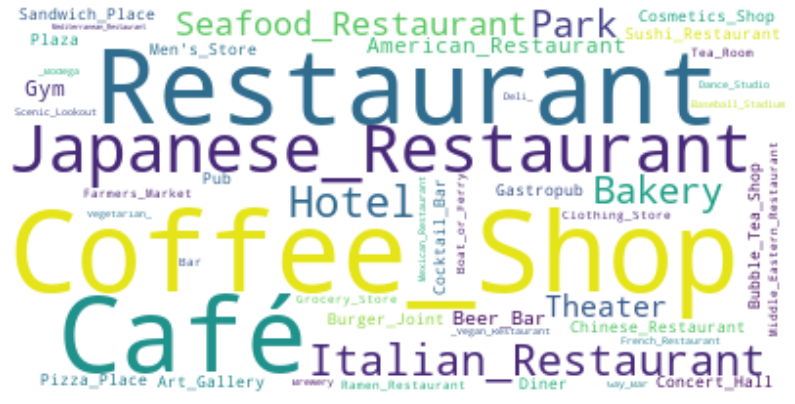

In [227]:
#get first cluster Neighborhoods(14 Neighborhoods)
words=get_words(0)
plot_wordCloud(words)

the most popular venues in the first Neighborhood group:

In [228]:
for i,venue in enumerate(list(alice_wc.words_.keys())[0:10]):
    print('{}.{} \n'.format(i+1,venue))

1.Coffee_Shop 

2.Restaurant 

3.Café 

4.Japanese_Restaurant 

5.Italian_Restaurant 

6.Hotel 

7.Park 

8.Bakery 

9.Seafood_Restaurant 

10.Theater 



### Second Neighborhood Group(Cluster)

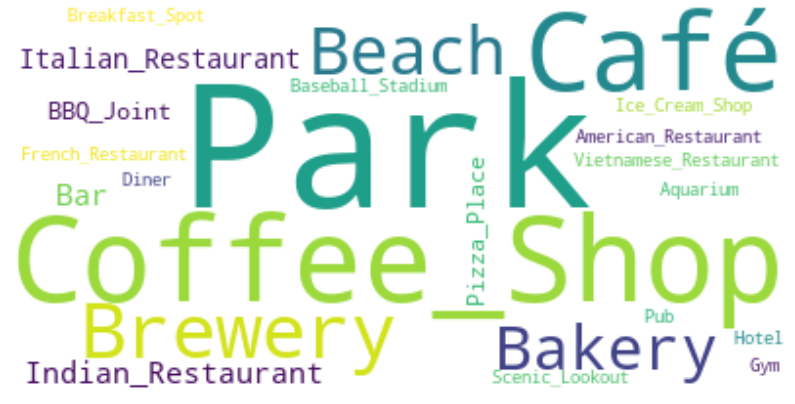

In [229]:
#get second cluster Neighborhood(5 Neighborhoods)
words=get_words(1)
plot_wordCloud(words)

the most popular venues in the second Neighborhood group:

In [230]:
for i,venue in enumerate(list(alice_wc.words_.keys())[0:10]):
    print('{}.{} \n'.format(i+1,venue))

1.Park 

2.Coffee_Shop 

3.Café 

4.Brewery 

5.Beach 

6.Bakery 

7.Indian_Restaurant 

8.Bar 

9.Italian_Restaurant 

10.BBQ_Joint 



### Third Neighborhood Group(Cluster)

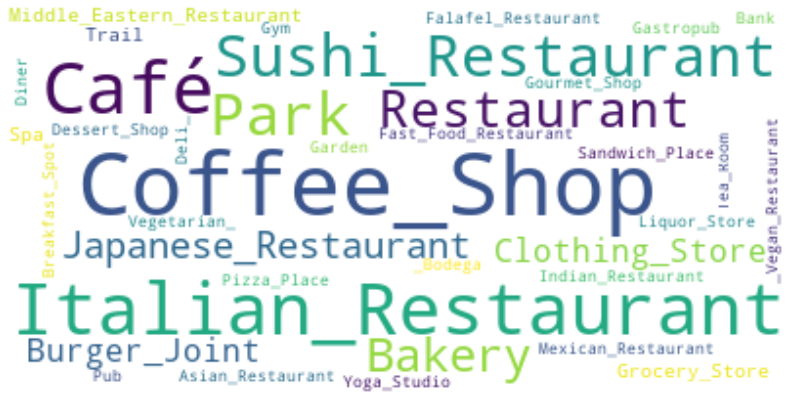

In [231]:
#get third cluster Neighborhood (9 Neighborhoods)
words=get_words(2)
plot_wordCloud(words)

the most popular venues in the second Neighborhood group:

In [232]:
for i,venue in enumerate(list(alice_wc.words_.keys())[0:10]):
    print('{}.{} \n'.format(i+1,venue))

1.Coffee_Shop 

2.Italian_Restaurant 

3.Café 

4.Sushi_Restaurant 

5.Park 

6.Restaurant 

7.Bakery 

8.Japanese_Restaurant 

9.Burger_Joint 

10.Clothing_Store 



### Fourth Neighborhood Group(Cluster)

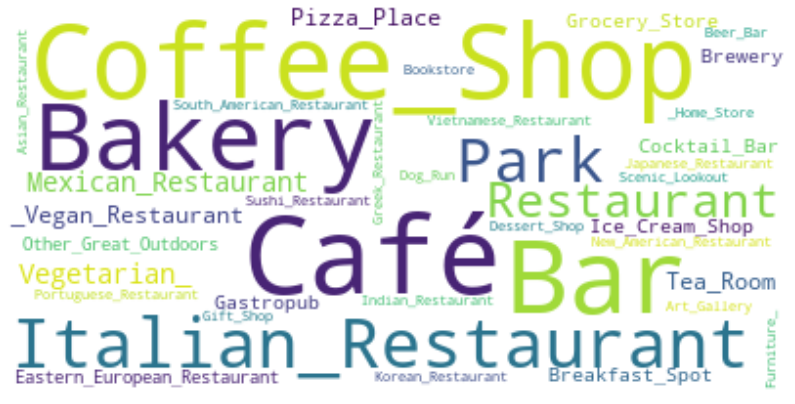

In [233]:
#get fourth cluster Neighborhood(11 Neighborhoods)
words=get_words(3)
plot_wordCloud(words)

the most popular venues in the second Neighborhood group:

In [234]:
for i,venue in enumerate(list(alice_wc.words_.keys())[0:10]):
    print('{}.{} \n'.format(i+1,venue))

1.Café 

2.Coffee_Shop 

3.Bar 

4.Bakery 

5.Italian_Restaurant 

6.Park 

7.Restaurant 

8.Mexican_Restaurant 

9.Vegetarian_ 

10._Vegan_Restaurant 



<p style='font-size:18px'>So its clear now to find the best Neigborhood in Toronton to live in according to the most popular Venue Types </p>
<p style='font-size:18px'> all you need is to look at the feature (venue category in each group to select your favourite Neighborhood)</p>